In [2]:
library(mclust)
library(cluster)
library(Rtsne)
library(uwot)
library(umap)
library(DESeq2)
library(amap)
library(tidyverse)
library(magrittr)
library("apeglm")
library("pheatmap")
library(Hobotnica)
library(pbapply)
library(reticulate)
library(limma)

In [4]:
count_matrix<- read.delim("C:\\Users\\Ermias\\Documents\\data visualization\\R_project\\GSE48216.countmatrix.full.txt",
                          row.names = 1,sep = ",")
anno<- read.delim("C:\\Users\\Ermias\\Documents\\data visualization\\R_project\\SraRunTable_GSE48216.pam50.txt",
                  row.names = 1,sep = ",")

In [5]:
map <- data.frame(
  gsm = c(
    "GSM1172844", "GSM1172845", "GSM1172846", "GSM1172847",
    "GSM1172848", "GSM1172849", "GSM1172850", "GSM1172851",
    "GSM1172853", "GSM1172854", "GSM1172856", "GSM1172858",
    "GSM1172859", "GSM1172860", "GSM1172861", "GSM1172864",
    "GSM1172865", "GSM1172867", "GSM1172868", "GSM1172869",
    "GSM1172870", "GSM1172871", "GSM1172872", "GSM1172873",
    "GSM1172874", "GSM1172876", "GSM1172878", "GSM1172879",
    "GSM1172882", "GSM1172883", "GSM1172884", "GSM1172885",
    "GSM1172886", "GSM1172888", "GSM1172890", "GSM1172895",
    "GSM1172897", "GSM1172901", "GSM1172903", "GSM1172904",
    "GSM1172906", "GSM1172907", "GSM1172908", "GSM1172909",
    "GSM1172910", "GSM1384316"
  ),
  sample = c(
    "MDAMB453", "SUM1315", "ZR75B", "MB157",
    "HCC1806", "HCC3153", "HCC38", "MDAMB175VII",
    "BT549", "UACC893", "MX1", "X184B5",
    "EFM192C", "X184A1", "HCC1599", "MCF10F",
    "BT474", "MDAMB231", "SUM229PE", "HCC2218",
    "HCC1395", "HCC1143", "SKBR3", "CAMA1",
    "MDAMB361", "X21MT2", "LY2", "X21MT1",
    "AU565", "SUM225CWN", "ZR7530", "HCC70",
    "MCF10A", "HCC1569", "BT483", "X21NT",
    "HCC1428", "SUM149PT", "X21PT", "HCC1937",
    "HCC1954", "HCC1419", "T47DKBluc", "MCF12A",
    "HS578T", "EFM192A"
  )
)

count_matrix_sub <- count_matrix[, map$sample]     
anno_sub <- anno[map$gsm, , drop=FALSE]           
rownames(anno_sub) <- map$sample                  
all(colnames(count_matrix_sub) == rownames(anno_sub))

v <- voom(count_matrix_sub, design=model.matrix(~ Group, data=anno_sub))
fit <- lmFit(v, design=model.matrix(~ Group, data=anno_sub))
count_matrix_int <- round(count_matrix_sub)

[1] TRUE

In [6]:
dds <-DESeqDataSetFromMatrix(countData = count_matrix_int,
                             colData = anno_sub,
                             design = ~ Group)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [7]:
head(anno_sub)
head(count_matrix_int)

,Group
,<chr>
MDAMB453,Non-malignant
SUM1315,Non-malignant
ZR75B,Basal
MB157,Basal
HCC1806,Basal
HCC3153,Basal


,MDAMB453,SUM1315,ZR75B,MB157,HCC1806,HCC3153,HCC38,MDAMB175VII,BT549,UACC893,⋯,HCC1428,SUM149PT,X21PT,HCC1937,HCC1954,HCC1419,T47DKBluc,MCF12A,HS578T,EFM192A
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,2,9,2,296,61,168,177,45,129,51,⋯,44,34,34,116,206,7,73,13,49,19
ENSG00000001167,136,254,62,141,163,183,89,122,291,106,⋯,163,77,289,98,122,99,106,170,165,104
ENSG00000005471,0,0,1,2,0,0,0,0,0,0,⋯,3,0,0,0,0,2,1,0,1,4
ENSG00000066629,0,116,33,3,17,90,171,12,31,0,⋯,79,0,7,8,8,35,35,19,119,60
ENSG00000154258,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000154262,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,2,0,0


In [8]:
dds

class: DESeqDataSet 
dim: 36953 46 
metadata(1): version
assays(1): counts
rownames(36953): ENSG00000000003 ENSG00000001167 ... ENSG00000154251
  ENSG00000154252
rowData names(0):
colnames(46): MDAMB453 SUM1315 ... HS578T EFM192A
colData names(1): Group

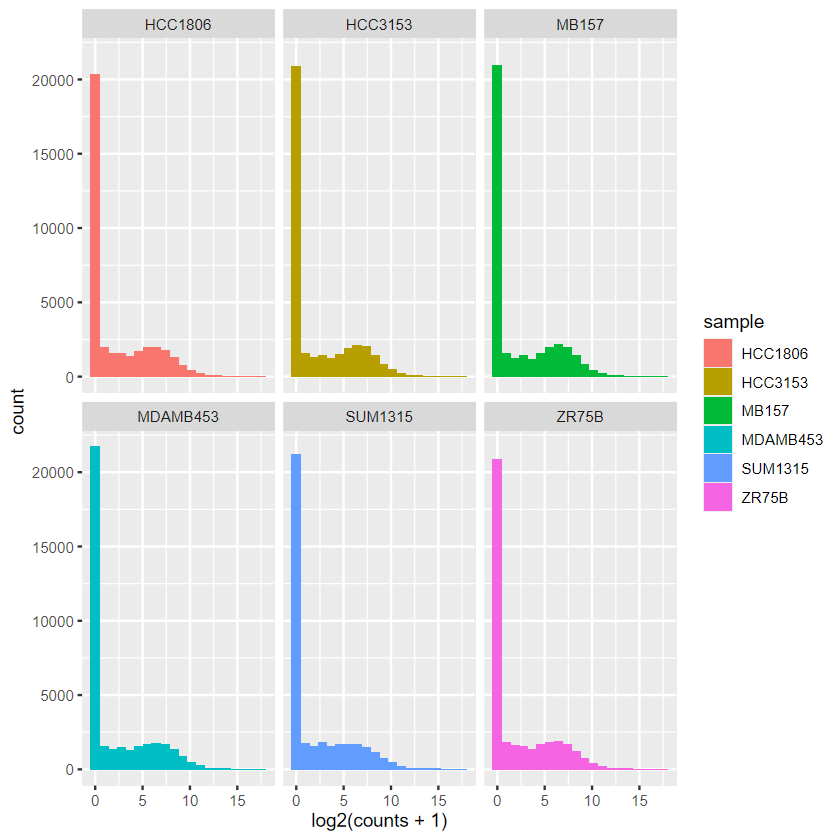

In [9]:
as_tibble(assay(dds), rownames = "Group") %>%
  pivot_longer(names_to = "sample", values_to = "counts", cols = 2:7) %>% 
  ggplot(aes(x = log2(counts + 1), fill = sample)) +
  geom_histogram(bins = 20) +
  facet_wrap(~ sample)

In [10]:
dds <- dds[rowSums(assay(dds)) > 0,]
dim(dds)

[1] 26933    46

In [11]:
dds <- DESeq(dds)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  fo

In [12]:
vsd <- vst(dds, blind = TRUE)

using ntop=500 top features by variance



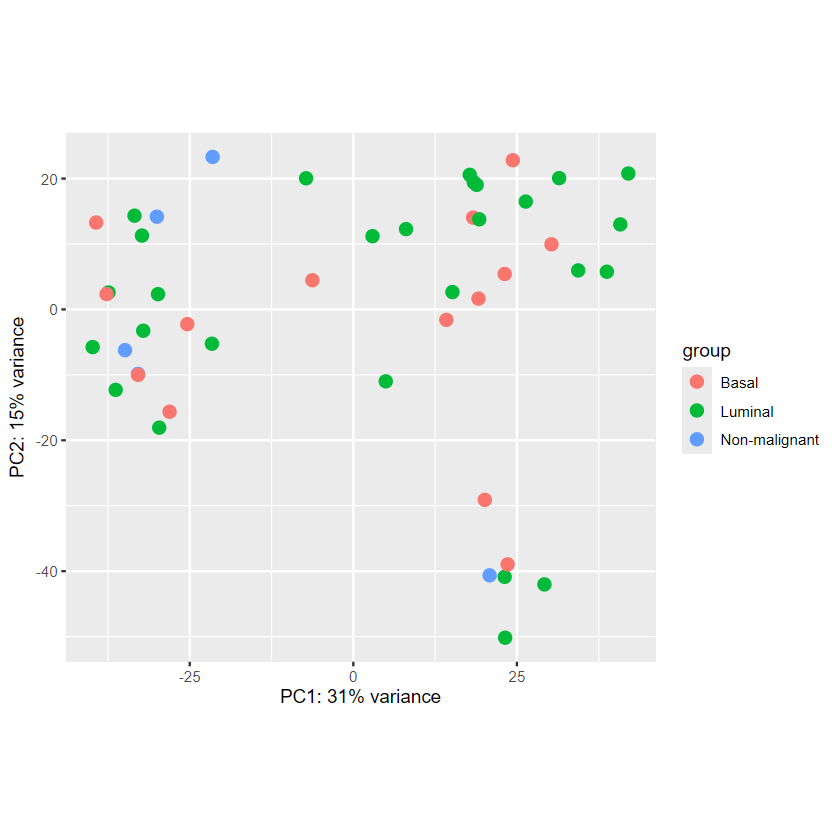

In [13]:
plotPCA(vsd,intgroup="Group")

In [14]:
colnames(colData(vsd))

[1] "Group"       "sizeFactor"  "replaceable"

In [15]:
pca_data <- plotPCA(vsd,intgroup="Group",returnData=TRUE)

using ntop=500 top features by variance



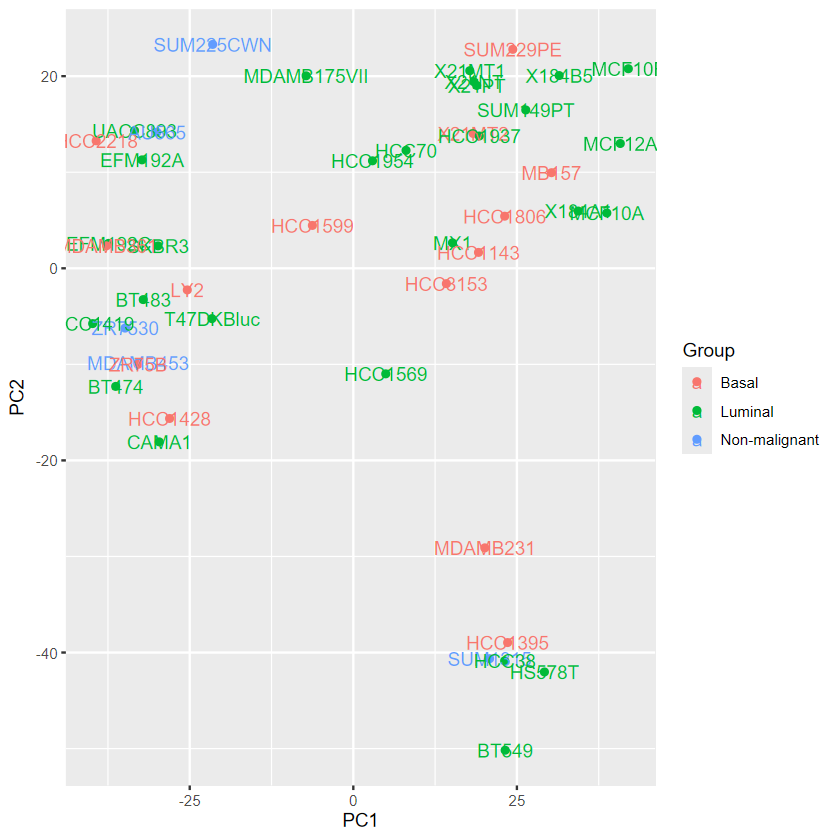

In [16]:
ggplot(pca_data,aes(x = PC1 , y= PC2,color = Group,label = name))+
  geom_point()+
  geom_text()

In [17]:
sizeFactors(dds)

MDAMB453     SUM1315       ZR75B       MB157     HCC1806     HCC3153 
  1.0501323   0.8507780   1.0028321   1.1678511   1.0321013   1.2662300 
      HCC38 MDAMB175VII       BT549     UACC893         MX1      X184B5 
  1.1192923   1.0303716   1.1681175   0.9051451   1.1731934   0.9449733 
    EFM192C      X184A1     HCC1599      MCF10F       BT474    MDAMB231 
  0.8212679   1.1291343   0.9986266   0.9954969   0.9819651   1.2217059 
   SUM229PE     HCC2218     HCC1395     HCC1143       SKBR3       CAMA1 
  0.9564829   0.7896092   1.0579759   1.0408705   1.1189079   1.1927716 
   MDAMB361      X21MT2         LY2      X21MT1       AU565   SUM225CWN 
  1.0060231   1.0398157   0.9948688   0.9706109   0.8214544   0.9146912 
     ZR7530       HCC70      MCF10A     HCC1569       BT483       X21NT 
  0.8696096   1.1505714   1.0848546   1.2291260   1.1357174   1.0262055 
    HCC1428    SUM149PT       X21PT     HCC1937     HCC1954     HCC1419 
  1.0413961   0.8409208   0.9991245   1.0639401   1.1206079   0.9845608 
  T47DKBluc      MCF12A      HS578T     EFM192A 
  1.2679099   0.8979809   0.9285357   0.8611644

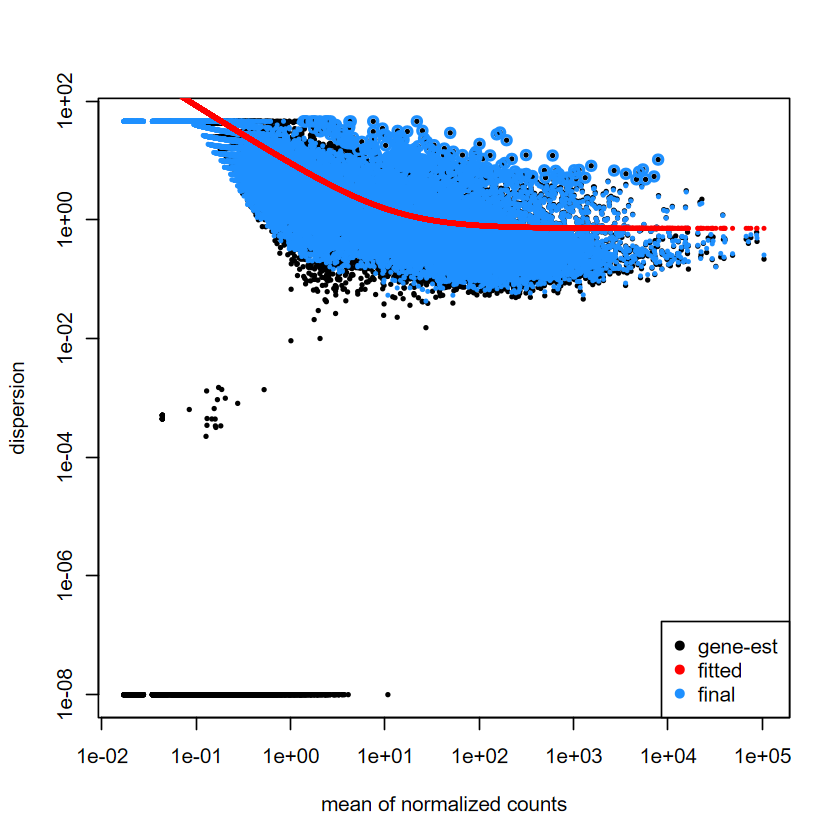

In [18]:
plotDispEsts(dds)

In [19]:
resultsNames(dds)

[1] "Intercept"                    "Group_Luminal_vs_Basal"      
[3] "Group_Non.malignant_vs_Basal"

In [20]:
dds$Group

[1] Non-malignant Non-malignant Basal         Basal         Basal        
 [6] Basal         Luminal       Luminal       Luminal       Luminal      
[11] Luminal       Luminal       Luminal       Luminal       Basal        
[16] Luminal       Luminal       Basal         Basal         Basal        
[21] Basal         Basal         Luminal       Luminal       Basal        
[26] Basal         Basal         Luminal       Non-malignant Non-malignant
[31] Non-malignant Luminal       Luminal       Luminal       Luminal      
[36] Luminal       Basal         Luminal       Luminal       Luminal      
[41] Luminal       Luminal       Luminal       Luminal       Luminal      
[46] Luminal      
Levels: Basal Luminal Non-malignant

In [21]:
levels(dds$Group)

[1] "Basal"         "Luminal"       "Non-malignant"

In [22]:
dds$Group <- relevel(dds$Group, ref = "Luminal")
dds <- DESeq(dds)
resultsNames(dds)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

-- replacing outliers and refitting for 1502 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersion

[1] "Intercept"                      "Group_Basal_vs_Luminal"        
[3] "Group_Non.malignant_vs_Luminal"

In [23]:
dds$Group <- factor(dds$Group)    # ensure factor
levels(dds$Group)

[1] "Luminal"       "Basal"         "Non-malignant"

In [24]:
res <- results(dds, 
                name = "Group_Basal_vs_Luminal")

In [25]:
res <- results(dds, contrast=c("Group", "Basal", "Luminal"))

In [26]:
res_tbl <- as_tibble(res, rownames = "ENSEMBL")
res_tbl

ENSEMBL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,71.12487922,0.222750988,0.4564209,0.48803851,0.62552256,0.9999447
ENSG00000001167,149.55834609,0.089062632,0.2237943,0.39796645,0.69065491,0.9999447
ENSG00000005471,0.69299109,0.216227695,1.0057522,0.21499103,0.82977431,NA
ENSG00000066629,34.79488892,-0.012908236,0.6252781,-0.02064399,0.98352965,0.9999447
ENSG00000154258,0.11089128,-0.537997619,3.2918147,-0.16343496,0.87017598,NA
ENSG00000154262,0.15352306,-0.438764911,3.2918147,-0.13328967,0.89396429,NA
ENSG00000154263,1.03872542,0.030682931,0.8541166,0.03592359,0.97134329,0.9999447
ENSG00000154265,6.75407451,-0.378943360,0.4892396,-0.77455570,0.43860224,0.9999447
ENSG00000154269,1.32855072,-2.188866234,1.2415788,-1.76297003,0.07790554,0.9487535


In [27]:
res_tbl <- as_tibble(res, rownames = "ENSEMBL")

res_tbl %>% 
  slice_head(n = 20)


ENSEMBL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,71.1248792,0.22275099,0.4564209,0.48803851,0.62552256,0.9999447
ENSG00000001167,149.5583461,0.08906263,0.2237943,0.39796645,0.69065491,0.9999447
ENSG00000005471,0.6929911,0.21622770,1.0057522,0.21499103,0.82977431,NA
ENSG00000066629,34.7948889,-0.01290824,0.6252781,-0.02064399,0.98352965,0.9999447
ENSG00000154258,0.1108913,-0.53799762,3.2918147,-0.16343496,0.87017598,NA
ENSG00000154262,0.1535231,-0.43876491,3.2918147,-0.13328967,0.89396429,NA
ENSG00000154263,1.0387254,0.03068293,0.8541166,0.03592359,0.97134329,0.9999447
ENSG00000154265,6.7540745,-0.37894336,0.4892396,-0.77455570,0.43860224,0.9999447
ENSG00000154269,1.3285507,-2.18886623,1.2415788,-1.76297003,0.07790554,0.9487535


In [28]:
res_tbl %>%
  arrange(padj) %>%
  head(20)


ENSEMBL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000176566,13.934038,-18.1663264,2.2492057,-8.076774,6.650255e-16,1.142846e-11
ENSG00000166825,857.454535,-7.2791089,1.0948386,-6.648568,2.959585e-11,2.543023e-07
ENSG00000179593,89.276148,-9.1195150,1.7947516,-5.081213,3.750325e-07,2.148311e-03
ENSG00000102854,56.992911,-4.1287708,0.8482627,-4.867326,1.131186e-06,4.859856e-03
ENSG00000136352,5.134485,4.8330546,1.0386820,4.653065,3.270373e-06,1.124027e-02
ENSG00000168918,31.286118,-5.2861573,1.1590481,-4.560775,5.096523e-06,1.138955e-02
ENSG00000172809,12877.097771,1.4273950,0.3151987,4.528556,5.938818e-06,1.138955e-02
ENSG00000083750,25.682113,-1.1591139,0.2515626,-4.607656,4.072333e-06,1.138955e-02
ENSG00000132274,29.905432,-4.6819723,1.0340887,-4.527631,5.964852e-06,1.138955e-02


In [29]:
top20_genes <- res_tbl %>% arrange(padj) %>% head(20) %>% pull(ENSEMBL)
top20_expr <- count_matrix_int[top20_genes, ]
dist_top20 <- amap::Dist(t(top20_expr), method = "kendall")
h_score_result <- Hobotnica(dist_top20, anno_sub$Group)
h_score_result
str(h_score_result)

[1] 0.4925166

 num 0.493


In [30]:
randomSignaturesList <- vector("list",1000)
all_genes <- rownames(count_matrix_int)
sig_length <- 40  # Since you want 40 genes in each subsample

if (length(all_genes) < sig_length) {
  stop(paste("Insufficient genes for random sampling. Available:", length(all_genes), "Needed:", sig_length))
}

for (i in 1:1000) {
  randomSignaturesList[[i]] <- sample(all_genes, sig_length)
}

randomSigScores <- pbsapply(randomSignaturesList, function(gset) {
  submat <- count_matrix_int[gset, , drop=FALSE]
  distMatrix <- as.matrix(Dist(t(submat), method="kendall", nbproc=40))
  Hobotnica(distMatrix, anno_sub$Group)
})
str(randomSigScores)

 num [1:1000] 0.5 0.541 0.48 0.554 0.526 ...


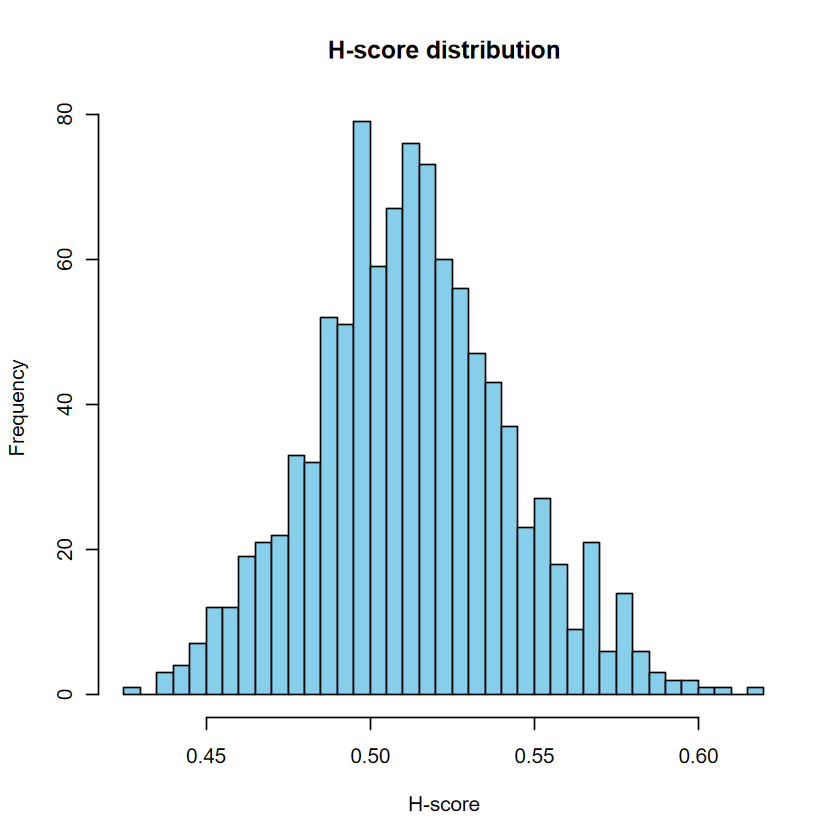

In [31]:
hist(randomSigScores, breaks = 50, main = "H-score distribution", xlab = "H-score", col = "skyblue")

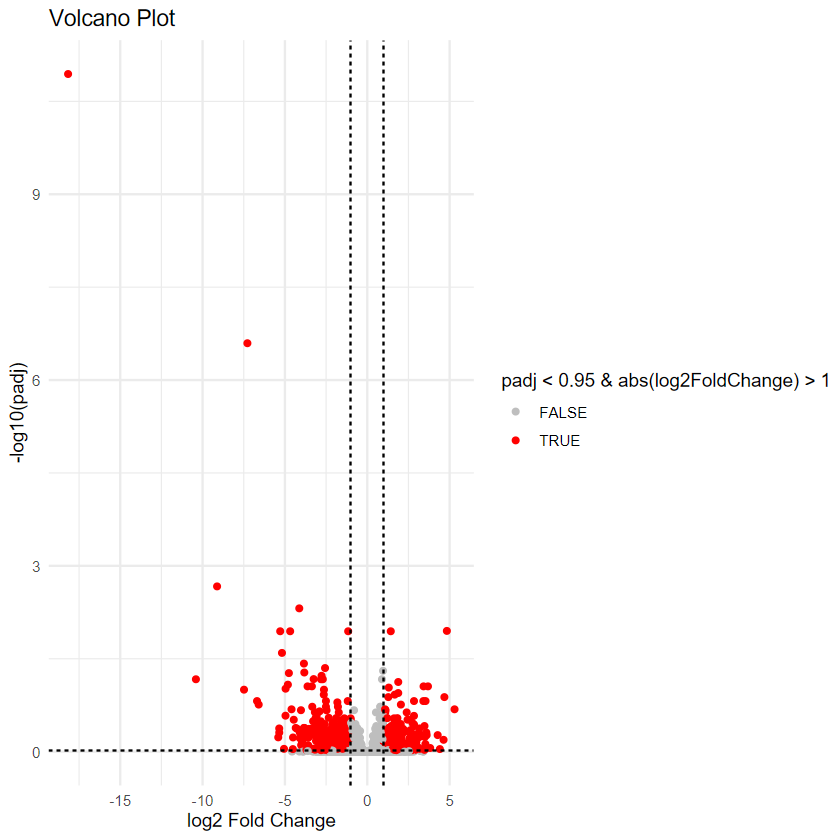

In [43]:
# Volcano plot using DESeq2 results
res_tbl %>%
  filter(!is.na(padj)) %>%
  ggplot(aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color = padj < 0.95 & abs(log2FoldChange) > 1), size = 1.2) +
  scale_color_manual(values = c("grey", "red")) +
  geom_hline(yintercept = -log10(0.95), linetype = "dashed") +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed") +
  labs(title = "Volcano Plot", x = "log2 Fold Change", y = "-log10(padj)") +
  theme_minimal()

using ntop=500 top features by variance



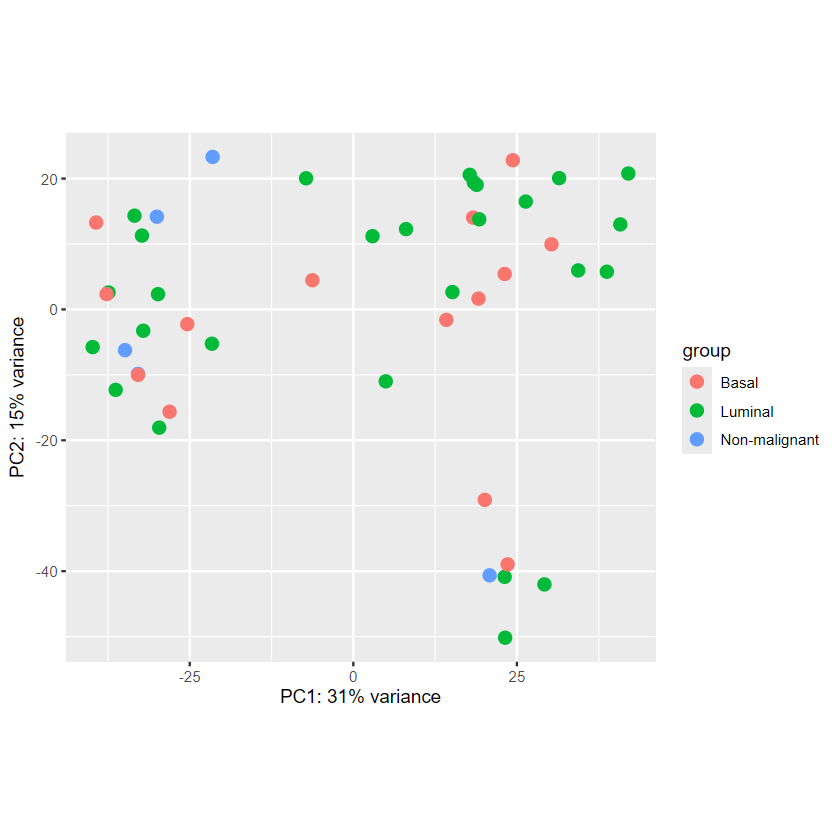

In [44]:
plotPCA(vsd,intgroup="Group")


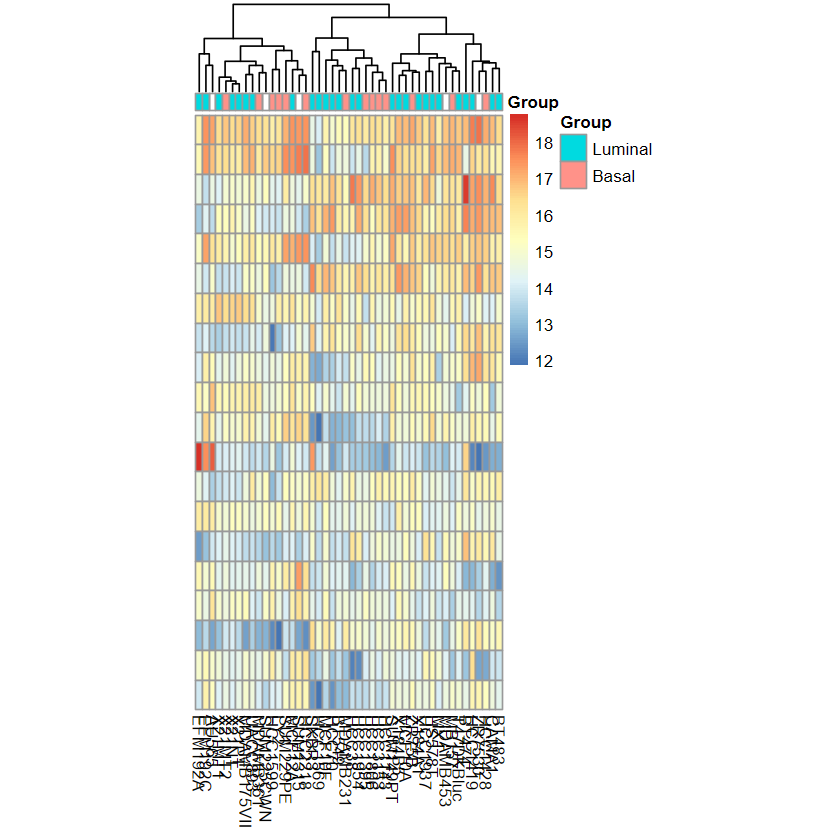

In [66]:
df <- as.data.frame(colData(dds)[, "Group",drop=FALSE])
df <- df[df$Group %in% c("Basal", "Luminal"),,drop=FALSE]
vsd_sub <- vsd[, rownames(df)]
select <- order(rowMeans(counts(dds, normalized=TRUE)), decreasing=TRUE)[1:20]
pheatmap(assay(vsd)[select,], 
         cluster_rows=FALSE, 
         show_rownames=FALSE,
         cluster_cols=TRUE, 
         annotation_col=df,
         cellwidth = 4)

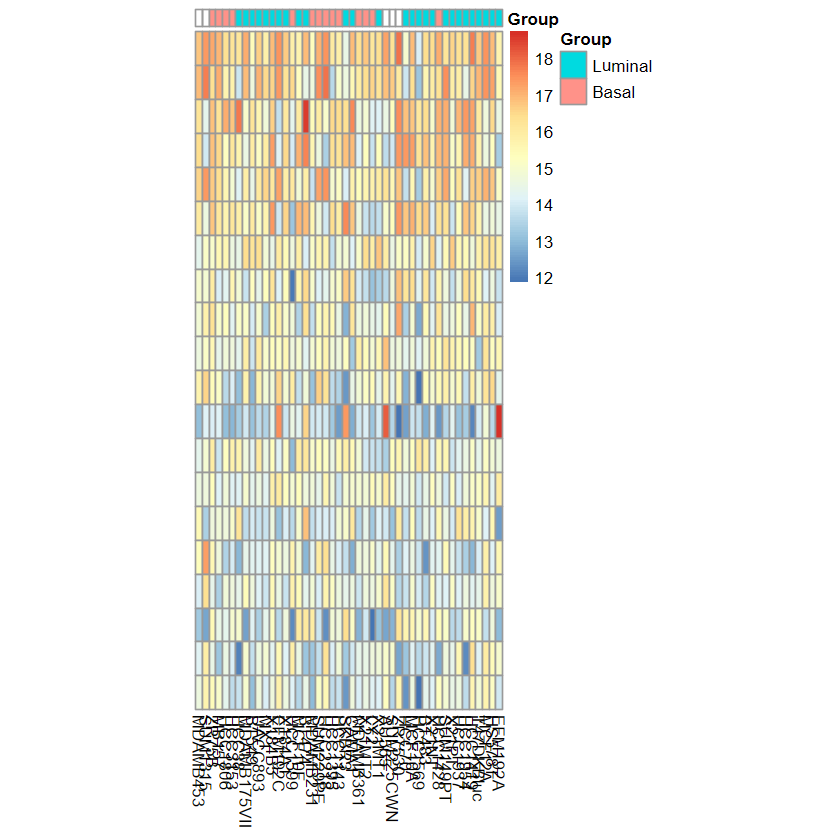

In [67]:
df <- as.data.frame(colData(dds)[, "Group",drop=FALSE])
df <- df[df$Group %in% c("Basal", "Luminal"),,drop=FALSE]
vsd_sub <- vsd[, rownames(df)]
select <- order(rowMeans(counts(dds, normalized=TRUE)), decreasing=TRUE)[1:20]
pheatmap(assay(vsd)[select,], 
         cluster_rows=FALSE, 
         show_rownames=FALSE,
         cluster_cols=FALSE, 
         annotation_col=df,
         cellwidth = 4)

[1] FALSE


        Basal       Luminal Non-malignant 
           14            27             5 

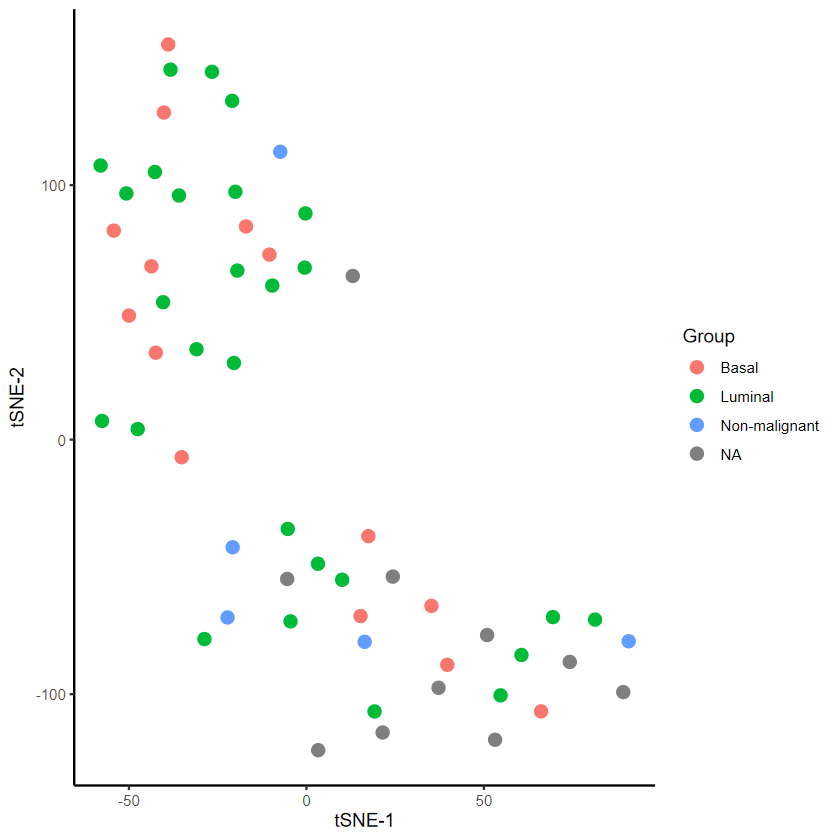

In [46]:
# Ensure Group is aligned and a factor
data <- log2(t(count_matrix) + 1)
data_clean <- data[complete.cases(data), ]
anyNA(data_clean)
Group <- anno_sub$Group[match(rownames(data_clean), rownames(anno_sub))]
Group <- factor(Group)  # convert to factor to avoid NA issues

# Run t-SNE
set.seed(10)
tsne_results <- Rtsne(data_clean,
                      perplexity = 10,
                      eta = 1000,
                      max_iter = 5000)

# Create a data.frame for plotting
Y <- as.data.frame(tsne_results$Y)
colnames(Y) <- c("tSNE1", "tSNE2")
Y$Group <- Group  

# Check for NA in Group
table(Y$Group)

# Plot
library(ggplot2)
ggplot(Y, aes(x = tSNE1, y = tSNE2, color = Group)) +
  geom_point(size = 3) +
  labs(x = "tSNE-1", y = "tSNE-2", color = "Group") +
  theme_classic()

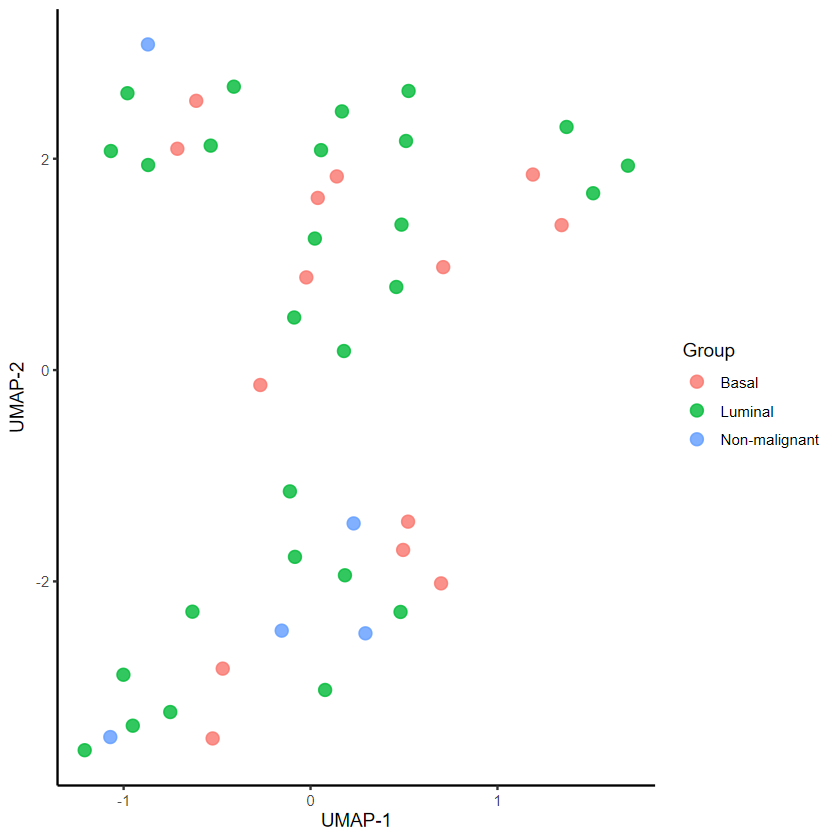

In [47]:
library(matrixStats)
var_genes <- order(rowVars(mat), decreasing = TRUE)[1:2000]
mat_var <- mat[var_genes, ]
umap_result <- umap(t(mat_var), n_neighbors = 15, min_dist = 0.1)
pca <- prcomp(t(mat), scale. = TRUE)
umap_result <- umap(pca$x[, 1:30], n_neighbors = 15, min_dist = 0.1)


mat <- assay(vsd)
meta <- colData(vsd)

# Transpose: samples as rows
umap_result <- umap(t(mat), n_neighbors = 15, min_dist = 0.1)

# Extract the layout (embedding coordinates)
umap_df <- as.data.frame(umap_result$layout)
colnames(umap_df) <- c("UMAP1", "UMAP2")

umap_df$Group <- meta$Group

ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Group)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(x = "UMAP-1", y = "UMAP-2", color = "Group") +
  theme_classic()


In [50]:
print(sil_pca)
print(sil_umap)
print(sil_tsne)
print(ari_pca)
print(ari_umap)
print(ari_tsne)


[1] 0.3825283
[1] 0.5921955
[1] 0.6117338
[1] 0.3625854
[1] 0.1439306
[1] 0.2509212


In [62]:
expr_t <- t(top20_expr)

# Align group labels BEFORE clustering and metrics
Group <- anno_sub$Group[match(rownames(expr_t), rownames(anno_sub))]
stopifnot(length(Group) == nrow(expr_t))

k <- length(unique(Group))

# --- PCA ---
pca_embed <- prcomp(expr_t, scale. = TRUE)$x[, 1:2]

# --- UMAP ---
set.seed(123)
umap_result <- umap::umap(expr_t)  # explicitly call umap package
umap_embed <- umap_result$layout

# --- t-SNE ---
set.seed(123)
tsne_embed <- Rtsne(expr_t, dims = 2, perplexity = 5)$Y

# --- Clustering ---
km_pca <- kmeans(pca_embed, centers = k)$cluster
km_umap <- kmeans(umap_embed, centers = k)$cluster
km_tsne <- kmeans(tsne_embed, centers = k)$cluster

# --- Metrics: Silhouette + ARI ---
sil_pca <- mean(silhouette(km_pca, dist(pca_embed))[, 3])
sil_umap <- mean(silhouette(km_umap, dist(umap_embed))[, 3])
sil_tsne <- mean(silhouette(km_tsne, dist(tsne_embed))[, 3])

ari_pca <- adjustedRandIndex(km_pca, Group)
ari_umap <- adjustedRandIndex(km_umap, Group)
ari_tsne <- adjustedRandIndex(km_tsne, Group)

# --- Hobotnica Score ---
dist_top20 <- amap::Dist(t(top20_expr), method = "kendall")
h_score_result <- Hobotnica(dist_top20, Group)

# --- Score Summary Table ---
score_df <- data.frame(
  Method = c("PCA", "UMAP", "t-SNE", "Hobotnica"),
  Silhouette = c(sil_pca, sil_umap, sil_tsne, NA),
  ARI = c(ari_pca, ari_umap, ari_tsne, NA)
)

print(score_df)

     Method Silhouette       ARI
1       PCA  0.3825283 0.3625854
2      UMAP  0.5921955 0.1439306
3     t-SNE  0.6117338 0.2509212
4 Hobotnica         NA        NA


In [63]:
randomSignaturesList <- vector("list", 1000)
all_genes <- rownames(count_matrix)
sig_length <- 40 
if (length(all_genes) < sig_length) {
  stop(paste("Insufficient genes for random sampling. Available:", length(all_genes), "Needed:", sig_length))
}

for (i in 1:1000) {
  randomSignaturesList[[i]] <- sample(all_genes, sig_length)
}

label_vector <- as.integer(factor(anno_sub$Group))

compute_metrics <- function(gset) {
  submat <- count_matrix_int[gset, , drop = FALSE]
  
  if (anyNA(submat)) return(rep(NA, 3))
  
  distMatrix <- as.matrix(Dist(t(submat), method = "kendall", nbproc = 40))
  #H_score
  hob_score <- Hobotnica(distMatrix, anno_sub$Group)
  
  # Silhouette score
  pam_clustering <- tryCatch({
    pam_res <- pam(distMatrix, k = length(unique(label_vector)))
    sil_score <- mean(silhouette(pam_res$clustering, distMatrix)[, 3])
    sil_score
  }, error = function(e) NA)
  
  # ARI
  ari_score <- tryCatch({
    pam_res <- pam(distMatrix, k = length(unique(label_vector)))
    adjustedRandIndex(pam_res$clustering, label_vector)
  }, error = function(e) NA)

  return(c(hob_score, sil_score, ari_score))
}

randomMetrics <- pbsapply(randomSignaturesList, compute_metrics)

randomMetrics_df <- as.data.frame(t(randomMetrics))
colnames(randomMetrics_df) <- c("H_score", "Silhouette", "ARI")

head(randomMetrics_df)

,H_score,Silhouette,ARI
,<dbl>,<dbl>,<dbl>
1,0.5153938,0.1479786,0.016236662
2,0.5384967,0.2140943,-0.012417466
3,0.5304479,0.2789908,-0.021438133
4,0.5197407,0.2753384,-0.010548762
5,0.4896761,0.3297700,-0.002668882
6,0.4970609,0.2563796,0.122394673


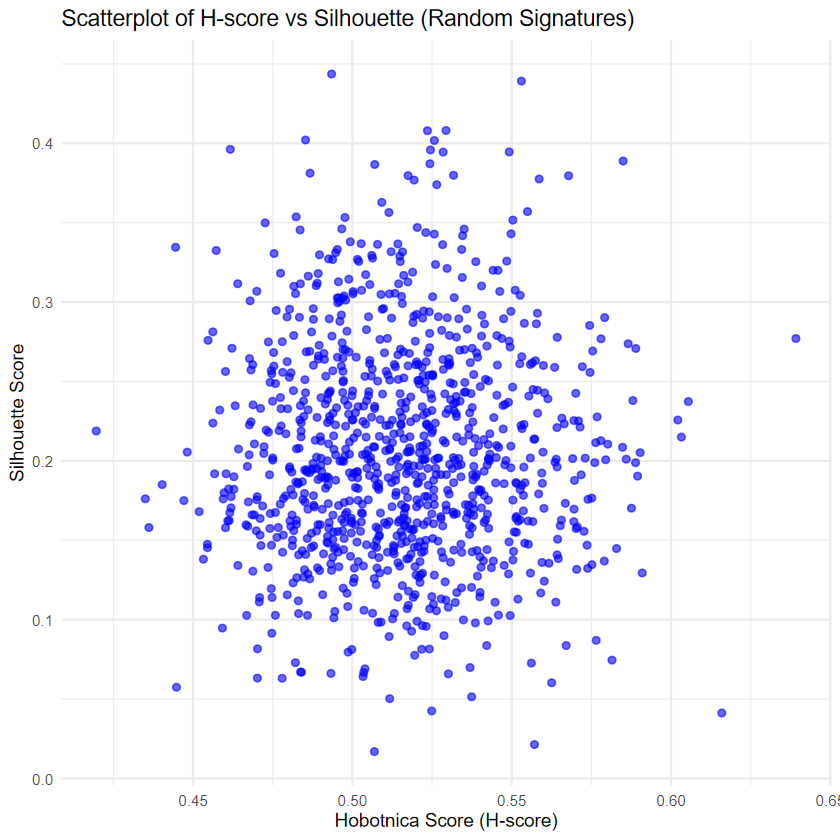

In [64]:
ggplot(randomMetrics_df, aes(x = H_score, y = Silhouette)) +
  geom_point(alpha = 0.6, color = "blue") +
  theme_minimal() +
  labs(title = "Scatterplot of H-score vs Silhouette (Random Signatures)",
       x = "Hobotnica Score (H-score)",
       y = "Silhouette Score")

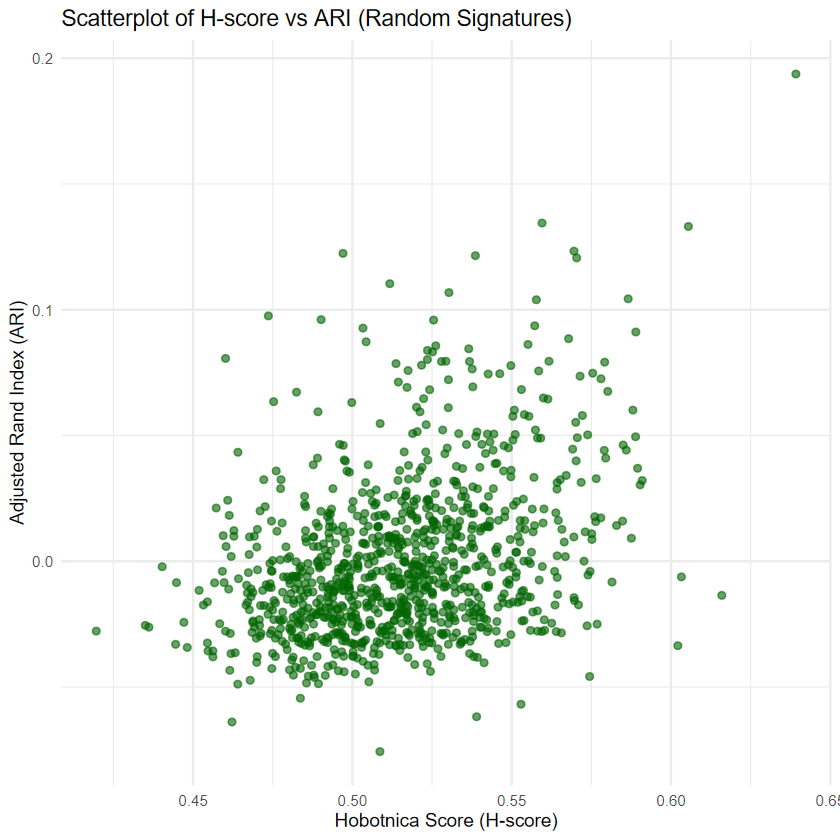

In [65]:
ggplot(randomMetrics_df, aes(x = H_score, y = ARI)) +
  geom_point(alpha = 0.6, color = "darkgreen") +
  theme_minimal() +
  labs(title = "Scatterplot of H-score vs ARI (Random Signatures)",
       x = "Hobotnica Score (H-score)",
       y = "Adjusted Rand Index (ARI)")